In [14]:
import torch
from torch import optim
import matplotlib.pyplot as plt
import numpy as np

# ------------------------------------------------------------
# 1. Sztuczny krajobraz straty (dla wizualizacji 2D)
# ------------------------------------------------------------
def loss_fn(xy):
    """
    Prosta funkcja straty: paraboloida + małe zaburzenia
    xy: tensor (2,)
    """
    x, y = xy[0], xy[1]
    return (x**2 + y**2) + 0.3*torch.sin(3*x) + 0.3*torch.sin(3*y)


# ------------------------------------------------------------
# 2. Własny optymalizator: SGD z momentum
# ------------------------------------------------------------
class SGDWithMomentum(optim.Optimizer):
    def __init__(self, params, lr, momentum=0.9):
        defaults = dict(lr=lr, momentum=momentum)
        super().__init__(params, defaults)

    def step(self):
        for group in self.param_groups:
            lr = group["lr"]
            momentum = group["momentum"]
            for p in group["params"]:
                if p.grad is None:
                    continue

                # Stan optymalizatora (jak w prawdziwym SGD)
                state = self.state[p]
                if "velocity" not in state:
                    state["velocity"] = torch.zeros_like(p.data)

                v = state["velocity"]
                grad = p.grad.data

                # v_t = μ v_{t-1} - lr * grad
                v.mul_(momentum).add_(grad, alpha=-lr)

                # param = param + v_t
                p.data.add_(v)


# ------------------------------------------------------------
# 3. Helper: wykonuje wiele kroków i zwraca historię parametrów
# ------------------------------------------------------------
def get_parameters_over_training(optimizer_cls, opt_kwargs, steps=100):
    # Parametr 2D (x, y)
    param = torch.nn.Parameter(torch.tensor([2.5, -3.0], dtype=torch.float32))

    optimizer = optimizer_cls([param], **opt_kwargs)

    params_list = []
    loss_list = []

    for _ in range(steps):
        optimizer.zero_grad()
        loss = loss_fn(param)
        loss.backward()
        optimizer.step()

        params_list.append(param.detach().clone().numpy())
        loss_list.append(loss.item())

    return np.array(params_list), np.array(loss_list)


# ------------------------------------------------------------
# 4. Rysowanie tła funkcji straty
# ------------------------------------------------------------
def loss_fig(smooth=True):
    fig, ax = plt.subplots(figsize=(6, 5))

    # Siatka do tła
    x = np.linspace(-4, 4, 200 if smooth else 50)
    y = np.linspace(-4, 4, 200 if smooth else 50)
    X, Y = np.meshgrid(x, y)

    Z = X**2 + Y**2 + 0.3*np.sin(3*X) + 0.3*np.sin(3*Y)

    ax.contourf(X, Y, Z, levels=40, cmap="viridis", alpha=0.7)
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_title("Loss landscape")
    return fig

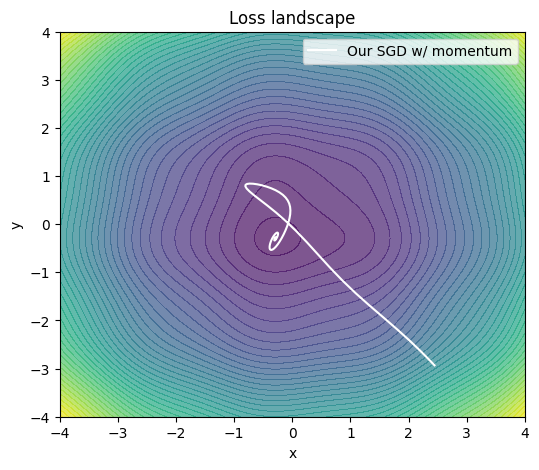

In [15]:
# ------------------------------------------------------------
# 5. Test własnego optymalizatora
# ------------------------------------------------------------

sgd_mom_params, sgd_mom_losses = get_parameters_over_training(
    SGDWithMomentum,
    opt_kwargs={"lr": 1e-2, "momentum": 0.9},
    steps=120
)

fig = loss_fig(True)
ax = fig.gca()
ax.plot(sgd_mom_params[:, 0], sgd_mom_params[:, 1],
        label="Our SGD w/ momentum", color="white")
ax.legend()
plt.show()

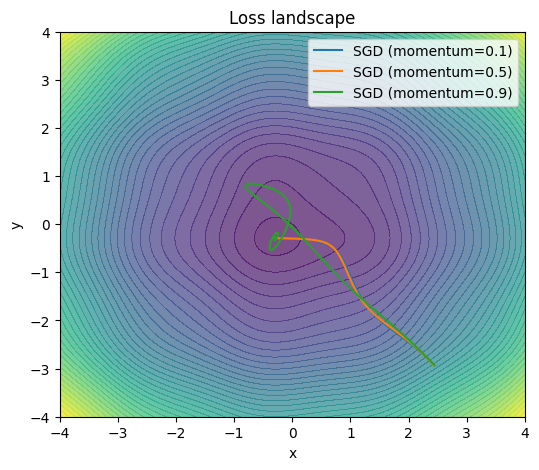

In [16]:
# ------------------------------------------------------------
# 6. Porównanie z wbudowanym PyTorch SGD
# ------------------------------------------------------------

sgd_small_mom_params, _ = get_parameters_over_training(
    optim.SGD,
    opt_kwargs={"lr": 1e-2, "momentum": 0.1},
)
sgd_med_mom_params, _ = get_parameters_over_training(
    optim.SGD,
    opt_kwargs={"lr": 1e-2, "momentum": 0.5},
)
sgd_large_mom_params, _ = get_parameters_over_training(
    optim.SGD,
    opt_kwargs={"lr": 1e-2, "momentum": 0.9},
)

fig = loss_fig(True)
ax = fig.gca()

ax.plot(sgd_small_mom_params[:,0], sgd_small_mom_params[:,1],
        label="SGD (momentum=0.1)")
ax.plot(sgd_med_mom_params[:,0], sgd_med_mom_params[:,1],
        label="SGD (momentum=0.5)")
ax.plot(sgd_large_mom_params[:,0], sgd_large_mom_params[:,1],
        label="SGD (momentum=0.9)")

ax.legend()
plt.show()

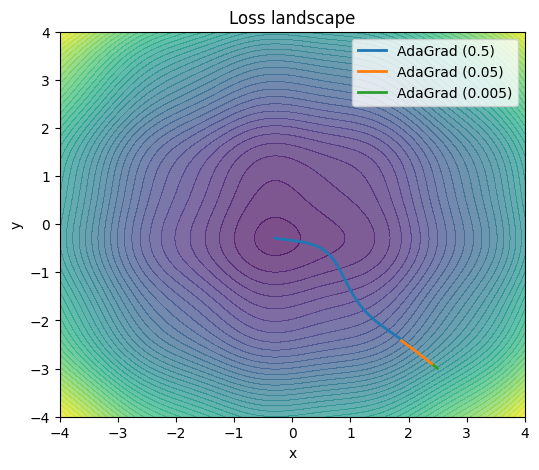

In [33]:
# ------------------------------------------------------------
# 7. Porównanie: AdaGrad dla roznych LR
# ------------------------------------------------------------


adagrad_params_0_5, _ = get_parameters_over_training(
    optim.Adagrad,
    opt_kwargs={"lr": 0.5},    # AdaGrad wymaga zwykle większego LR
    steps=50
)


adagrad_params_0_05, _ = get_parameters_over_training(
    optim.Adagrad,
    opt_kwargs={"lr": 0.05},    # AdaGrad wymaga zwykle większego LR
    steps=50
)

adagrad_params_0_005, _ = get_parameters_over_training(
    optim.Adagrad,
    opt_kwargs={"lr": 0.005},    # AdaGrad wymaga zwykle większego LR
    steps=50
)

fig = loss_fig(smooth=True)
ax = fig.gca()

ax.plot(adagrad_params_0_5[:, 0], adagrad_params_0_5[:, 1],
        label="AdaGrad (0.5)", linewidth=2)

ax.plot(adagrad_params_0_05[:, 0], adagrad_params_0_05[:, 1],
        label="AdaGrad (0.05)", linewidth=2)

ax.plot(adagrad_params_0_005[:, 0], adagrad_params_0_005[:, 1],
        label="AdaGrad (0.005)", linewidth=2)
ax.legend()
plt.show()


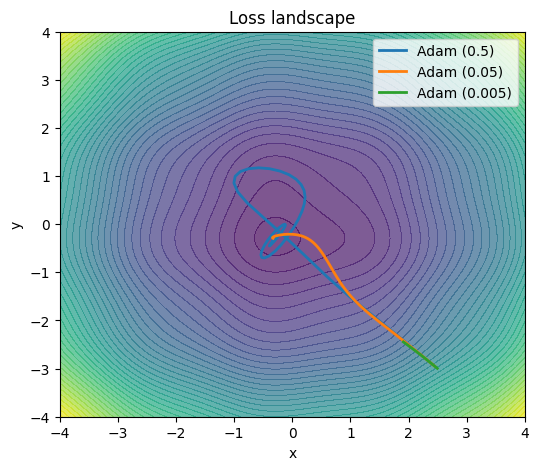

In [39]:


adagrad_params_0_5, _ = get_parameters_over_training(
    optim.Adam,
    opt_kwargs={"lr": 0.5},    
    steps=120
)


adagrad_params_0_05, _ = get_parameters_over_training(
    optim.Adam,
    opt_kwargs={"lr": 0.05},    
    steps=120
)

adagrad_params_0_005, _ = get_parameters_over_training(
    optim.Adam,
    opt_kwargs={"lr": 0.005},    
    steps=120
)

fig = loss_fig(smooth=True)
ax = fig.gca()

ax.plot(adagrad_params_0_5[:, 0], adagrad_params_0_5[:, 1],
        label="Adam (0.5)", linewidth=2)

ax.plot(adagrad_params_0_05[:, 0], adagrad_params_0_05[:, 1],
        label="Adam (0.05)", linewidth=2)

ax.plot(adagrad_params_0_005[:, 0], adagrad_params_0_005[:, 1],
        label="Adam (0.005)", linewidth=2)
ax.legend()
plt.show()

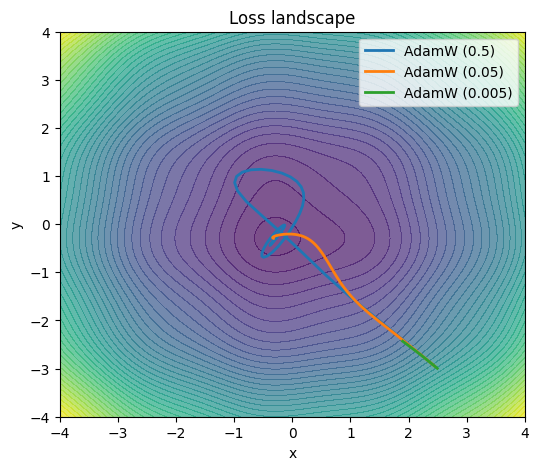

In [38]:


adagrad_params_0_5, _ = get_parameters_over_training(
    optim.AdamW,
    opt_kwargs={"lr": 0.5},    
    steps=120
)


adagrad_params_0_05, _ = get_parameters_over_training(
    optim.AdamW,
    opt_kwargs={"lr": 0.05},    
    steps=120
)

adagrad_params_0_005, _ = get_parameters_over_training(
    optim.AdamW,
    opt_kwargs={"lr": 0.005},    
    steps=120
)

fig = loss_fig(smooth=True)
ax = fig.gca()

ax.plot(adagrad_params_0_5[:, 0], adagrad_params_0_5[:, 1],
        label="AdamW (0.5)", linewidth=2)

ax.plot(adagrad_params_0_05[:, 0], adagrad_params_0_05[:, 1],
        label="AdamW (0.05)", linewidth=2)

ax.plot(adagrad_params_0_005[:, 0], adagrad_params_0_005[:, 1],
        label="AdamW (0.005)", linewidth=2)
ax.legend()
plt.show()

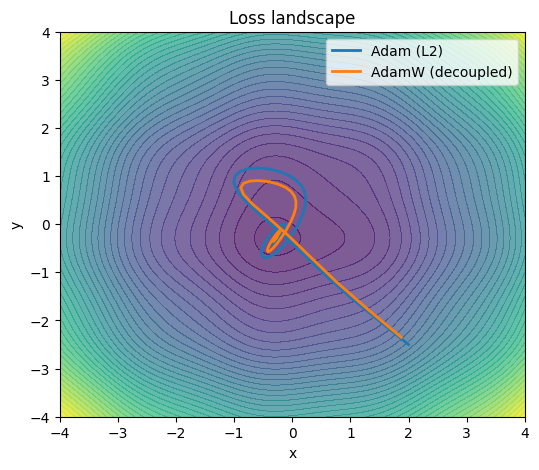

In [41]:
adam_params, _ = get_parameters_over_training(
    optim.Adam,
    opt_kwargs={"lr": 0.5, "weight_decay": 0.1},   # L2 reg
    steps=120
)

adamw_params, _ = get_parameters_over_training(
    optim.AdamW,
    opt_kwargs={"lr": 0.5, "weight_decay": 0.1},   # decoupled decay
    steps=120
)

fig = loss_fig(True)
ax = fig.gca()

ax.plot(adam_params[:,0], adam_params[:,1], label="Adam (L2)", linewidth=2)
ax.plot(adamw_params[:,0], adamw_params[:,1], label="AdamW (decoupled)", linewidth=2)

ax.legend()
plt.show()


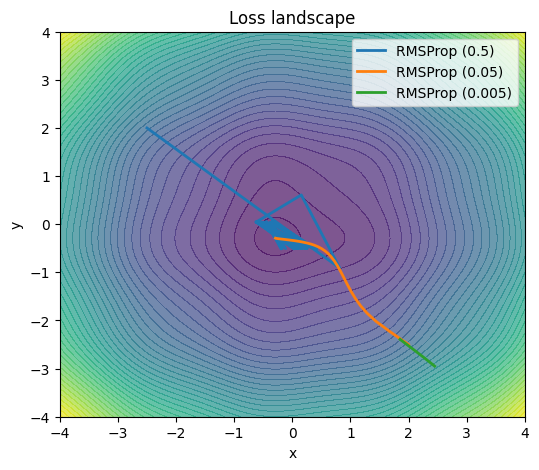

In [35]:
# ------------------------------------------------------------
# Porównanie: RMSProp dla roznych LR
# ------------------------------------------------------------


rmsprop_params_0_5, _ = get_parameters_over_training(
    optim.RMSprop,
    opt_kwargs={"lr": 0.5},    # AdaGrad wymaga zwykle większego LR
    steps=50
)


rmsprop_params_0_05, _ = get_parameters_over_training(
    optim.RMSprop,
    opt_kwargs={"lr": 0.05},    # AdaGrad wymaga zwykle większego LR
    steps=50
)

rmsprop_params_0_005, _ = get_parameters_over_training(
    optim.RMSprop,
    opt_kwargs={"lr": 0.005},    # AdaGrad wymaga zwykle większego LR
    steps=50
)

fig = loss_fig(smooth=True)
ax = fig.gca()

ax.plot(rmsprop_params_0_5[:, 0], rmsprop_params_0_5[:, 1],
        label="RMSProp (0.5)", linewidth=2)

ax.plot(rmsprop_params_0_05[:, 0], rmsprop_params_0_05[:, 1],
        label="RMSProp (0.05)", linewidth=2)

ax.plot(rmsprop_params_0_005[:, 0], rmsprop_params_0_005[:, 1],
        label="RMSProp (0.005)", linewidth=2)
ax.legend()
plt.show()

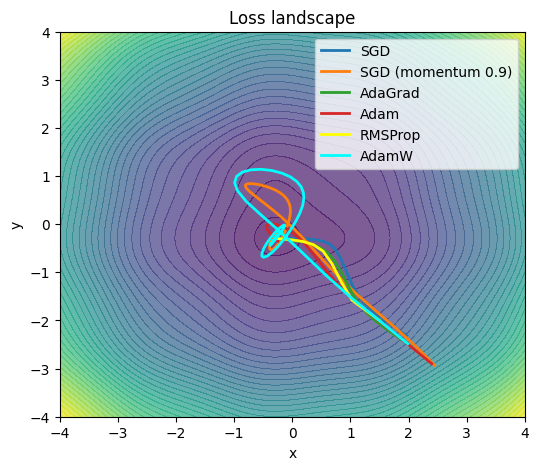

In [34]:
# ------------------------------------------------------------
# 7. Porównanie: SGD / Momentum / AdaGrad / Adam na jednym wykresie
# ------------------------------------------------------------

sgd_params, _ = get_parameters_over_training(
    optim.SGD,
    opt_kwargs={"lr": 0.1, "momentum": 0.0},   # zwykły SGD
    steps=120
)

momentum_params, _ = get_parameters_over_training(
    optim.SGD,
    opt_kwargs={"lr": 1e-2, "momentum": 0.9},
    steps=120
)

adagrad_params, _ = get_parameters_over_training(
    optim.Adagrad,
    opt_kwargs={"lr": 0.5},    # AdaGrad wymaga zwykle większego LR
    steps=120
)

adam_params, _ = get_parameters_over_training(
    optim.Adam,
    opt_kwargs={"lr": 0.1},    # Adam działa stabilnie przy większym LR
    steps=120
)


rmpsprop_params, _ = get_parameters_over_training(
    optim.RMSprop,
    opt_kwargs={"lr": 1e-1},    
    steps=120
)

adamw_params, _ = get_parameters_over_training(
    optim.AdamW,
    opt_kwargs={"lr": 5e-1},    
    steps=120
)
# ------------------------------------------------------------
# 8. Rysowanie wspólnego wykresu
# ------------------------------------------------------------

fig = loss_fig(smooth=True)
ax = fig.gca()

ax.plot(sgd_params[:, 0], sgd_params[:, 1],
        label="SGD", linewidth=2)

ax.plot(momentum_params[:, 0], momentum_params[:, 1],
        label="SGD (momentum 0.9)", linewidth=2)

ax.plot(adagrad_params[:, 0], adagrad_params[:, 1],
        label="AdaGrad", linewidth=2)

ax.plot(adam_params[:, 0], adam_params[:, 1],
        label="Adam", linewidth=2)


ax.plot(rmpsprop_params[:, 0], rmpsprop_params[:, 1],
        label="RMSProp", linewidth=2, c="yellow")

ax.plot(adamw_params[:, 0], adamw_params[:, 1],
        label="AdamW", linewidth=2, c="cyan")
ax.legend()
plt.show()
